In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cbn_datagen as cbn_dg
import cbn_ae_datagen as cbn_ae_dg

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
import tensorflow as tf
import pickle
import numpy as np
import scipy
from scipy.signal import find_peaks
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from metrics import *

# receiver antennas
N = 16

# bits
L = 16

# no. of sources
K = 4

C = [8, 16, 32]

# snr between 5 and 30 dB
snrs = [5, 10, 15, 20, 25, 30]

resolution = 180
samples = 5000

doa = np.pi*np.random.rand(K,samples) - np.pi/2

labels_, data_ = cbn_dg.generate_bulk_data(samples, N, K, L)

cutoff = 0.5

In [45]:
mse_cbn = []
    
prec_cbn = []

rec_cbn = []

cbn_cov_model = load_model(f"models/CBN_recv_full_N={N}_K={K}_L={L}")

def cbn_cov(model, data_, labels_, snr):
    labels = np.copy(labels_)
    data = np.copy(data_)
    data = cbn_dg.apply_wgn(data, L, snr)
    
    data = np.concatenate((data.real,data.imag), axis=1)
    data = data.reshape((samples, 2*N*L))
    data = data / np.max(np.abs(data), axis=1).reshape((samples,1))
    
    print(data.shape)
    
    pred = model.predict(data)    
    
    pred_conv = np.zeros((len(labels), K))
    labels_conv = np.zeros((len(labels), K))
    
        
    for i in range(len(pred)):
        n = int(np.sum(labels[i]))
        pred_theta = (-pred[i]).argsort()[:n].copy()        
        pred_theta.sort()
        pred_conv[i][:n] = pred_theta / 180 #* np.pi - np.pi/2
        
        pred[i][pred[i] < cutoff] = 0
        pred[i][pred[i] >= cutoff] = 1
        
        temp = (-labels[i]).argsort()[:n].copy()
        temp.sort()
        labels_conv[i][:n] = temp / 180 #* np.pi - np.pi/2
    
    print(pred_theta)
    
    m = mean_squared_error(labels_conv.T, pred_conv.T) / mean_squared_error(labels_conv.T, np.zeros(labels_conv.T.shape))
    
    p = tf.keras.metrics.Precision(thresholds=cutoff)
    p.update_state(labels, pred)
    prec = p.result().numpy()
    
    r = tf.keras.metrics.Recall(thresholds=cutoff)
    r.update_state(labels, pred)
    rec = r.result().numpy()
        
    mse_cbn.append(m)
    prec_cbn.append(prec)
    rec_cbn.append(rec)
    
for s in snrs:
    snr = [s, s]
    print(s)
    cbn_cov(cbn_cov_model, data_, labels_, snr)

5
(5000, 512)
[106 115 116 133]
10
(5000, 512)
[107 115 132 133]
15
(5000, 512)
[ 88 107 130 133]
20
(5000, 512)
[  0 107 115 116]
25
(5000, 512)
[ 88 107 115 116]
30
(5000, 512)
[ 88 107 130 133]


In [36]:
mse_cbn

[0.12530905313883173,
 0.12198301503915843,
 0.12041551744105446,
 0.12086785246222176,
 0.12052679890480415,
 0.12003334896020032]

In [46]:
cbn_ae_type = 'CBN_ae'

cbn_ae_legend = 'cbn autoenc'

mse_cbn_ae = {}
prec_cbn_ae = {}
rec_cbn_ae = {}

for c in C:
    mse_cbn_ae[f'{cbn_ae_legend} C={c}'] = []
    prec_cbn_ae[f'{cbn_ae_legend} C={c}'] = []
    rec_cbn_ae[f'{cbn_ae_legend} C={c}'] = []

    
def cbn_autoenc(model, autoenc, data_, labels_, snr, c):
    labels = np.copy(labels_)
    data = np.copy(data_)
    data = cbn_dg.apply_wgn(data, L, snr)
    
    data = np.concatenate((data.real,data.imag), axis=1)
    data = data.reshape((samples, 2*N*L))
    #data = data - np.min(data, axis=1).reshape((samples, 1))
    data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))

    data = autoenc(data)
    
    pred = model.predict(data)
    #pred = pred / np.max(pred, axis=1).reshape(samples,1)
        
    pred_conv = np.zeros((len(pred), K))
    labels_conv = np.zeros((len(pred), K))
    
        
    for i in range(len(pred)):
        n = int(np.sum(labels[i]))
        
        pred[i][pred[i] < cutoff] = 0
        pred[i][pred[i] >= cutoff] = 1
        
        pred_theta = (-pred[i]).argsort()[:n].copy()        
        pred_theta.sort()
        pred_conv[i][:n] = pred_theta / 180 #* np.pi - np.pi/2        
        
        temp = (-labels[i]).argsort()[:n].copy()
        temp.sort()
        labels_conv[i][:n] = temp / 180 #* np.pi - np.pi/2
        
    print(temp)
        
    m = mean_squared_error(labels_conv.T, pred_conv.T) / mean_squared_error(labels_conv.T, np.zeros(labels_conv.T.shape))
    
    p = tf.keras.metrics.Precision(thresholds=cutoff)
    p.update_state(labels, pred)
    prec = p.result().numpy()
    
    r = tf.keras.metrics.Recall(thresholds=cutoff)
    r.update_state(labels, pred)
    rec = r.result().numpy()
        
    mse_cbn_ae[f'{cbn_ae_legend} C={c}'].append(m)
    prec_cbn_ae[f'{cbn_ae_legend} C={c}'].append(prec)
    rec_cbn_ae[f'{cbn_ae_legend} C={c}'].append(rec)
    

cbn_autoenc_models = []
autoencoder_models = []

for c in C:
    cbn_autoenc_models.append(load_model(f"models/{cbn_ae_type}_C={c}_N={N}_K={K}_L={L}"))
    autoencoder_models.append(load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}").layers[1])


for s in snrs:
    snr = [s, s]
    print(s)    
    for c in C:
        i = C.index(c)
        cbn_autoenc(cbn_autoenc_models[i], autoencoder_models[i], data_, labels_, snr, c)      
        
        


5
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]
10
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]
15
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]
20
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]
25
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]
30
[ 45  89 107 133]
[ 45  89 107 133]
[ 45  89 107 133]


'\nplt.figure(3)\n\ncbn_history = pickle.load(open(f"history/CBN_N={N}_K={K}_L={L}", \'rb\'))\nplt.plot(cbn_history[\'loss\'])\nplt.plot(cbn_history[\'val_loss\'])\nplt.legend([\'training\', \'validation\'])\nplt.xlabel(\'epoch\')\nplt.ylabel(\'binary cross entropy\')\nplt.savefig(f"figures/experiment_cbn_vb_cbn_autoenc/CBN_loss_N={N}_K={K}_L={L}.png", format=\'png\')\n'

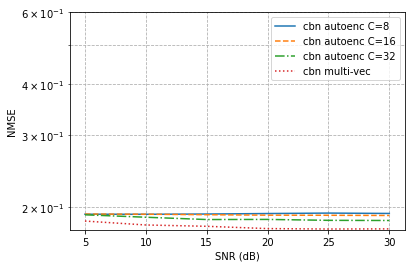

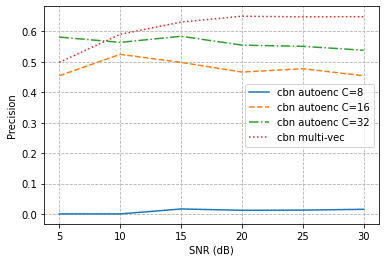

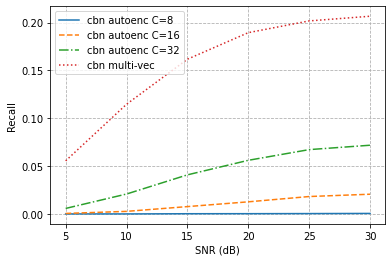

In [47]:
from itertools import cycle

mse = mse_cbn_ae
mse['cbn multi-vec'] = mse_cbn

prec = prec_cbn_ae
prec['cbn multi-vec'] = prec_cbn

rec = rec_cbn_ae
rec['cbn multi-vec'] = rec_cbn


plt.figure(0)
plt.tight_layout()


lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.grid(True, which="both", linestyle='--')

for i in list(mse.keys()):
    plt.semilogy(snrs, mse[i], next(linecycler))

plt.ylabel('NMSE')
plt.xlabel('SNR (dB)')
plt.ylim([None, 0.6])
plt.legend(list(mse.keys()))
#plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/mse_N={N}_K={K}_L={L}.png', bbox_inches='tight')

plt.figure(1)
plt.tight_layout()


lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.grid(True, which="both", linestyle='--')

for i in list(prec.keys()):
    plt.plot(snrs, prec[i], next(linecycler))
    
plt.ylabel('Precision')
plt.xlabel('SNR (dB)')
plt.legend(list(prec.keys()))
#plt.ylim([0.83, None])
#plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/precision_pos_N={N}_K={K}_L={L}.png', bbox_inches='tight')

plt.figure(2)
plt.tight_layout()


lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.grid(True, which="both", linestyle='--')

for i in list(rec.keys()):
    plt.plot(snrs, rec[i], next(linecycler))
    
plt.ylabel('Recall')
plt.xlabel('SNR (dB)')
plt.legend(list(prec.keys()))
#plt.ylim([0.83, None])
#plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/recall_pos_N={N}_K={K}_L={L}.png', bbox_inches='tight')

"""
plt.figure(3)

cbn_history = pickle.load(open(f"history/CBN_N={N}_K={K}_L={L}", 'rb'))
plt.plot(cbn_history['loss'])
plt.plot(cbn_history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.ylabel('binary cross entropy')
plt.savefig(f"figures/experiment_cbn_vb_cbn_autoenc/CBN_loss_N={N}_K={K}_L={L}.png", format='png')
"""


In [31]:
autoenc_mse = {}

samples = 5000
    
K = 8
C = [8, 16, 32]

cbn_autoenc_labels, cbn_autoenc_data = cbn_ae_dg.generate_bulk_data(samples, N, K, L)

for c in C:
    autoenc_model = load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}")
    

    for s in snrs:
        snr = [s, s]
        print(s)
        
        data = np.copy(cbn_autoenc_data)
    
        data = cbn_ae_dg.apply_wgn(data, L, snr)
        data = np.concatenate((data.real,data.imag), axis=1)    
        data = data.reshape((samples, 2*L*N))
        
        labels = data.copy()
        labels = labels - np.min(labels, axis=1).reshape((samples,1))
        labels = labels / np.max(np.abs(labels), axis=1).reshape((samples, 1))
        
        data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))
        
        pred = autoenc_model.predict(data)
        
        m = mean_squared_error(labels, pred) / mean_squared_error(labels, np.zeros(labels.shape))
        
        name = f'autoenc C={c}'
        
        if name not in autoenc_mse:
            autoenc_mse[name] = []
        
        autoenc_mse[name].append(m)

5
10
15
20
25
30
5
10
15
20
25
30
5
10
15
20
25
30


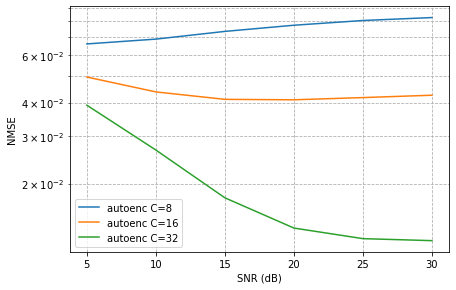

In [32]:
from itertools import cycle

plt.figure(6)
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.grid(True, which="both", linestyle='--')

plt.tight_layout()

for i in list(autoenc_mse.keys()):
    plt.semilogy(snrs, autoenc_mse[i])

plt.ylabel('NMSE')
plt.xlabel('SNR (dB)')
plt.legend(list(autoenc_mse.keys()))
plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/autoenc_mse_N={N}_K={K}_L={L}.png', bbox_inches='tight')

5
10
15
20
25
30
5
10
15
20
25
30
5
10
15
20
25
30


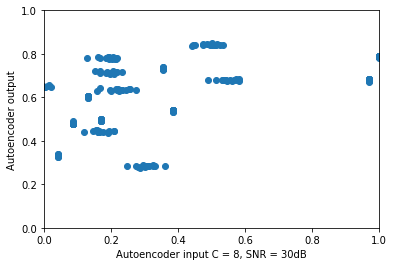

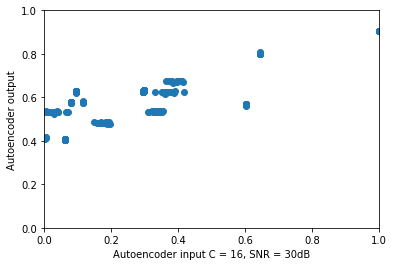

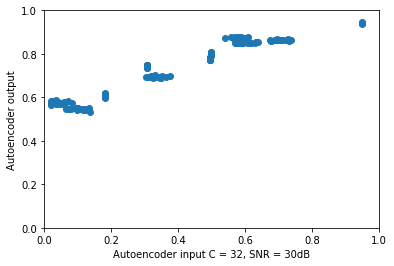

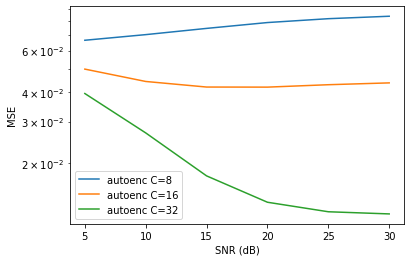

In [28]:
autoenc_mse = {}
    
K = 8
C = [8,16,32]

for c in C:
    autoenc_model = load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}")

    cbn_autoenc_labels, cbn_autoenc_data = cbn_ae_dg.generate_bulk_data(samples, N, K, L)

    for s in snrs:
        snr = [s, s]
        print(s)
                
        data = np.copy(cbn_autoenc_data)
    
        data = cbn_ae_dg.apply_wgn(data, L, snr)
        data = np.concatenate((data.real,data.imag), axis=1)    
        data = data.reshape((samples, 2*L*N))
        
        labels = data.copy()
        labels = labels - np.min(labels, axis=1).reshape((samples,1))
        labels = labels / np.max(np.abs(labels), axis=1).reshape((samples, 1))
        
        data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))
        
        pred = autoenc_model.predict(data)
        
        m = mean_squared_error(labels, pred) / mean_squared_error(labels, np.zeros(labels.shape))
        
        name = f'autoenc C={c}'
        
        if name not in autoenc_mse:
            autoenc_mse[name] = []
        
        autoenc_mse[name].append(m)
        
    plt.figure()
        
    plt.ylabel('Autoencoder output')
    plt.xlabel(f'Autoencoder input C = {c}, SNR = 30dB')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.scatter(data[0], pred[0])

        
plt.figure(6)
for i in list(autoenc_mse.keys()):
    plt.semilogy(snrs, autoenc_mse[i])
    autoenc_mse[i].clear()

plt.ylabel('MSE')
plt.xlabel('SNR (dB)')
#plt.ylim([None, 5e-5])
plt.legend(list(autoenc_mse.keys()))



In [ ]:
mse